In [1]:
import numpy as np
import pandas as pd
import subprocess
import os
import csv
import json
import matplotlib.pyplot as plt
from IPython.display import display, clear_output, Image

def generate_data(mode, file_name, *args):
    print(args)
    arguments = " ".join([f"{a}" for a in args]);
    compile_command = "make NaSch"
    run_command = f"./NaSch {mode} {file_name} {arguments}"

    clear_output(wait=True)
    display("Compiling File...")
    subprocess.run(compile_command, shell=True, capture_output=True, text=True)
    clear_output(wait=True)
    display("Generating Data...")
    subprocess.run(run_command, shell=True, capture_output=True, text=True)
    clear_output(wait=True)
    display("Done!")

## Global Variables

Here we set up the variables which must remain consistent over all simulations. 

- **Length** : 4000 cells * 7.5 meters per cell = 30km of road.
- **p** : All vehicles have a 50% chance of breaking.

In [2]:

global length
global p
length = 4000
p = 0.5

## Regular Nagel-Schreckenberg Global Variables

Here we set up the variables which must remain constant over all the regular NaSch simulations.

- **Cells per vehicle** : Equivalent to $1 / \rho$, ranging from 2 -> 10.
- **Velocities** : Chosen to match existing speed limits.

In [3]:

global regular_cells_per_vehicle
global regular_velocities
regular_cells_per_vehicle = list(range(2, 11))
regular_velocities = dict(json.load(open("speeds.json")))

## Mean Stationary Vehicles and Throughput

Here we generate the data for all variations of the regular NaSch model. 
This will help us choose which density and corresponding throughput to use going forward.

In [25]:

def perform_regular_NaSch(length, v_max, p, num_vehicles, N):
    filename = "out.txt"
    
    throughput, stationary = [], []
    
    for val in regular_cells_per_vehicle:
        generate_data(1, filename, length, v_max, p, val, num_vehicles, N)
        mean_throughput = np.mean(np.genfromtxt("throughput.txt", delimiter=',')[:-1])
        mean_stationary = np.mean(np.genfromtxt(filename, delimiter=',')[:-1])
        throughput.append(mean_throughput)
        stationary.append(mean_stationary)
    
    csv_name = f"../Data/Regular_NaSch_vmax{v_max}.csv"
    with open(csv_name, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['cells_per_vehicle', 'mean_throughput', 'mean_stationary'])
        for index in range(len(regular_cells_per_vehicle)):
            writer.writerow([regular_cells_per_vehicle[index], throughput[index], stationary[index]])

num_vehicles = 1
N = 100000

for vmax in regular_velocities.values():
    perform_regular_NaSch(length, vmax, p, num_vehicles, N)

'Done!'

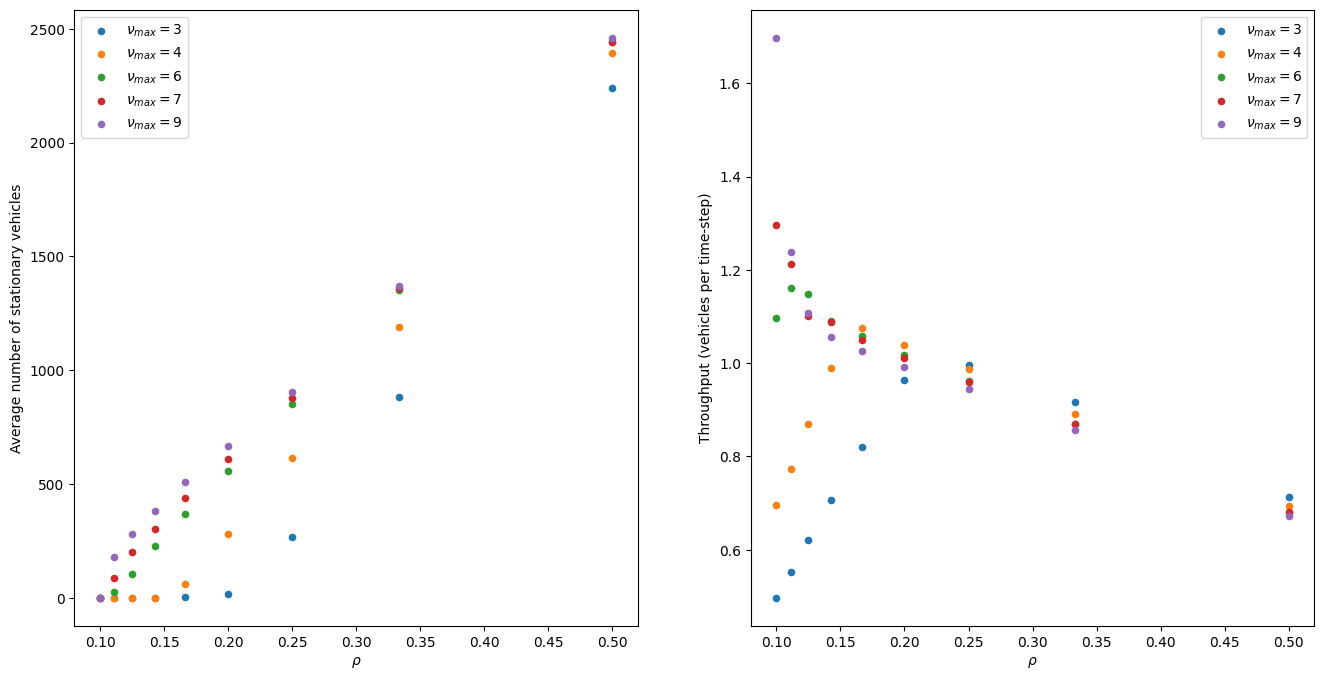

In [11]:

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

for vmax in regular_velocities.values():
    filename = f"../Data/Regular_NaSch_vmax{vmax}.csv"
    data = pd.read_csv(filename)
    density = [1 / float(val) for val in data['cells_per_vehicle']]
    mean_throughput = data['mean_throughput']
    mean_stationary = data['mean_stationary']
    
    # Plot Stationary Vehicles
    ax1.scatter(density, mean_stationary, s=20)
    ax1.set(xlabel=r'$\rho$', ylabel='Average number of stationary vehicles')
    ax1.legend([r'$\nu_{max}=3$', r'$\nu_{max}=4$', r'$\nu_{max}=6$', r'$\nu_{max}=7$', r'$\nu_{max}=9$'])
    
    # Plot Throughput
    ax2.scatter(density, mean_throughput, s=20)
    ax2.set(xlabel=r'$\rho$', ylabel='Throughput (vehicles per time-step)')
    ax2.legend([r'$\nu_{max}=3$', r'$\nu_{max}=4$', r'$\nu_{max}=6$', r'$\nu_{max}=7$', r'$\nu_{max}=9$'])
    
plot_name = "../Report/Regular_NaSch.png"
f.savefig(plot_name, dpi=1000, transparent=False, bbox_inches='tight')
Image(plot_name, width=800);

## Choosing $\rho$

0.1 is the only $\rho$ value which has 0 stationary vehicles on average for all values of $\nu_{max}$. </br>
Now we take a closer look at this density. More specifically, let's look at the mean and RMS error for its corresponding measure of 10 cells per vehicle.

In [31]:

def examine_rho(v_max, cells_per, num_vehicles, N):
    filename = "out.txt"
    
    generate_data(1, filename, length, v_max, p, cells_per, num_vehicles, N)
    throughput = np.genfromtxt("throughput.txt", delimiter=',')[:-1]
    stationary = np.genfromtxt(filename, delimiter=',')[:-1]
    steps = list(range(1, N+1))
    
    csv_name = f"../Data/Examine_rho_vmax{v_max}.csv"
    with open(csv_name, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['step', 'throughput', 'stationary'])
        for index in range(len(steps)):
            writer.writerow([steps[index], throughput[index], stationary[index]])

num_vehicles = 1
N = 100000
one_over_rho = 10

for vmax in regular_velocities.values():
    examine_rho(vmax, one_over_rho, num_vehicles, N)

'Done!'

In [32]:
# Calculate RMS Errors

for vmax in regular_velocities.values():
    
    filename = f"../Data/Examine_rho_vmax{vmax}.csv"
    data = pd.read_csv(filename)
    steps = data['step']
    throughput = data['throughput']
    stationary = data['stationary']
    
    # Mean
    mean_throughput = np.mean(throughput)
    mean_stationary = np.mean(stationary)
    
    # RMS
    rms_throughput = np.sqrt(sum((1/(N-1)) * (x - mean_throughput)**2 for x in throughput) / N)
    rms_stationary = np.sqrt(sum((1/(N-1)) * (x - mean_stationary)**2 for x in stationary) / N)
    
    print(f"\nv_max = {vmax}:\n")
    print("Throughput:")
    print(f"Mean: {mean_throughput}, RMS: {rms_throughput}")
    print(f"99.7% chance mu is between {mean_throughput - 3 * rms_throughput} and {mean_throughput + 3 * rms_throughput}\n")
    
    print("Stationary Vehicles:")
    print(f"Mean: {mean_stationary}, RMS: {rms_stationary}")
    print(f"99.7% chance mu is between {mean_stationary - 3 * rms_stationary} and {mean_stationary + 3 * rms_stationary}\n")


v_max = 3:

Throughput:
Mean: 0.49719, RMS: 0.00208349812782362
99.7% chance mu is between 0.49093950561652916 and 0.5034404943834708

Stationary Vehicles:
Mean: 0.10369, RMS: 0.001098997687421468
99.7% chance mu is between 0.1003930069377356 and 0.1069869930622644


v_max = 4:

Throughput:
Mean: 0.69686, RMS: 0.0024100455363333926
99.7% chance mu is between 0.6896298633909999 and 0.7040901366090002

Stationary Vehicles:
Mean: 0.00655, RMS: 0.00029541808969406113
99.7% chance mu is between 0.005663745730917817 and 0.007436254269082183


v_max = 6:

Throughput:
Mean: 1.09672, RMS: 0.0029405337752512954
99.7% chance mu is between 1.087898398674246 and 1.1055416013257537

Stationary Vehicles:
Mean: 0.01065, RMS: 0.0010591397418522907
99.7% chance mu is between 0.007472580774443127 and 0.013827419225556872


v_max = 7:

Throughput:
Mean: 1.29713, RMS: 0.0031634692516887396
99.7% chance mu is between 1.2876395922449337 and 1.306620407755066

Stationary Vehicles:
Mean: 0.0, RMS: 0.0
99.7% c

In [10]:
# Clean Notebook

if os.path.exists("out.txt"):
    os.remove("out.txt")
    
if os.path.exists("throughput.txt"):
    os.remove("throughput.txt")

if os.path.exists("NaSch"):
    os.remove("NaSch")